## AML Project - FX prediction with Markovian model

Below you will find a primitive trading algorithm, called Baseline, which is based on 'momentum of expectations' and an other one with Hidden Markov ideas 

##### Data: https://www.kaggle.com/imetomi/eur-usd-forex-pair-historical-data-2002-2019

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import time

from abc import ABC, abstractmethod
import random as rn
import sys

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sb

---
---
### Style & Context

In [3]:
sb.set_context('notebook')
sb.set_style('darkgrid')
sb.set_palette('deep')

In [4]:
sys.setrecursionlimit(15000)

---
---
### Utils

General

In [5]:
def string_to_date(d):
    def is_weekday(dt): return dt.weekday() < 5

    y, m, d = map(lambda x: int(x), d.split('-'))
    if (is_weekday(dt.date(y, m, d))): return dt.date(y, m, d)
    else: return dt.date(1,1,1) # for filtering the data

def string_to_hour(x): return int(x.split(':')[0])

def data_slice_by_date(df, start, end): return df[(df.Date >= start) & (df.Date <= end)]

#def pd_matrix_power(df, n):
#    labels = ('s','u','d')
#    return pd.DataFrame(np.matrix(df)**n, index=labels, columns=labels)

def pd_matrix_product(df1, df2):
    cols = df2.columns
    idc = df1.index
    return pd.DataFrame(np.matrix(df1)*np.matrix(df2), index=idc, columns=cols)

data_utils_dict = {'s2d':string_to_date,
                   's2h':string_to_hour,
                   'slice_by_date':data_slice_by_date,
                   #'mpow':pd_matrix_power,
                   'mprod':pd_matrix_product}
data_utils = pd.Series(data_utils_dict)

In [6]:
def progress_bar(i, n):
    size = 70
    done = (i+1)/n
    x = int(size*done)

    clear_output(wait=True)
    return '\t{:.1f}% [{}{}]'.format(done*100, '#'*x, ' '*(size-x))

def run_trading(mkt, agts):
    start = time.time()
    i = -1
    while mkt.date.year == year:
        [agt.trade(mkt) for agt in agts]
        mkt.next_day()
        i += 1
        print(progress_bar(i,365))
    print( 'runtime: {t:.2f} min'.format(t=(time.time()-start)/60) )

def plot_trading(agts, f_color):
    plt.figure(figsize=(15,7))
    [sb.lineplot(x=range(len(agt.history)), y=agt.history, color=f_color(agt)) for agt in agts]
    plt.show()

#run_utils_dict = {'run':run_trading, 'plot':plot_trading}
#run_utils = pd.Series(run_utils_dict)

HiddenMarkov

In [7]:
def data_step(df, nbin_change=5, nbin_spread=3):
    data_hmm = df.loc[:, ('Date','Hour')]
    
    data_hmm['BidChange'] = pd.qcut(df.BidChange / df.BidLow, nbin_change, labels=range(nbin_change))
    data_hmm['AskChange'] = pd.qcut(df.AskChange / df.AskLow, nbin_change, labels=range(nbin_change))
    
    data_hmm['BidSpread'] = pd.qcut((df.BidHigh - df.BidLow)/df.BidLow, nbin_spread, labels=range(nbin_spread))
    data_hmm['AskSpread'] = pd.qcut((df.AskHigh - df.AskLow)/df.AskLow, nbin_spread, labels=range(nbin_spread))
    
    data_hmm.drop(data_hmm.tail(1).index,inplace=True)
    data_hmm['NextHour'] = list(df.BidChange.apply(np.sign)[1:] + df.AskChange.apply(np.sign)[1:])
    
    data_hmm['TagDetail'] = data_hmm.BidChange.astype(str) + data_hmm.BidSpread.astype(str) + data_hmm.AskChange.astype(str) + data_hmm.AskSpread.astype(str)
    data_hmm['TagSimple'] = data_hmm.BidChange.astype(str) + data_hmm.AskChange.astype(str)
    data_hmm = data_hmm[['Date', 'Hour', 'TagSimple', 'TagDetail', 'NextHour']]
    
    return data_hmm

def transition_frequencies(timeSeries):
    events = ('s','u','d')
    
    freq = pd.DataFrame(0, index=events, columns=events)
    for i in range(len(timeSeries)-1):
        r, c = [events[int(i/2)] for i in [timeSeries[i], timeSeries[i+1]]]
        freq[c][r] += 1
        
    return freq
    
def yx_joint_frequencies(timeSeries):
    events = ('s','u','d')
    idxs = set(timeSeries.TagDetail)
    
    freq = pd.DataFrame(0, index=idxs, columns=events)
    for idx in idxs:
        for x in [-2, 0, 2]:
            freq[events[int(x/2)]][idx] = len(timeSeries[(timeSeries.TagDetail==idx) & (timeSeries.NextHour==x)])
    
    return freq

def frequencies_to_probabilities(df):
    sums = df.sum(axis=1)
    for row in df.index:
        df.loc[[row]] /= sums[row]
        
hmm_utils_dict = {'ds':data_step, 
                  'tr_freq':transition_frequencies, 
                  'xy_freq':yx_joint_frequencies,
                  'freq2prob':frequencies_to_probabilities}
hmm_utils = pd.Series(hmm_utils_dict)

---
---
### Infrastructure

In [8]:
class Market():
    def __init__(self, d=dt.date(2005,4,1)):
        self.date = d

    def next_day(self): 
        self.date += dt.timedelta(days=1)

    def is_open(self):
        return len(data[data.Date==mkt.date].Hour) == 24

    def ask_at(self, h):
        return float(data[(data.Date==self.date) & (data.Hour==h)].AskClose)

    def bid_at(self, h):
        return float(data[(data.Date==self.date) & (data.Hour==h)].BidClose)

    # representation & visualization
    def __repr__(self): 
        return 'FX-EUR/USD, {}'.format(self.date.strftime('%Y-%m-%d, %a'))
    
    def plot_day(self, cols=['BidOpen', 'AskOpen']):
        plt.figure(figsize=(15,5))
        plt.title(self.__repr__())
        [sb.lineplot(data=data[data.Date==self.date], x='Hour', y=col) for col in cols]
        plt.show()

In [9]:
class Account(ABC):
    def __init__(self, eur, usd, model='-'):
        self.model = model
        self.eur = eur
        self.usd = usd
        self.liquid = True
        self.history = []
    
    def net_at(self, market, h): # the value of the portfolio in EUR at a given hour of the day 
        return self.eur + self.usd / market.ask_at(h)

    def rebalance(self, market, ratio, h=12):
        to_trade = self.net_at(market, h) * ratio - self.eur
        if (to_trade < 0):
            self.eur += to_trade
            self.usd -= to_trade * market.bid_at(h)
        else:
            self.eur += to_trade
            self.usd -= to_trade * market.ask_at(h)

    @abstractmethod
    def trade(self, market):
        pass

    def __repr__(self):
        return "({}|€{:.0f}|${:.0f})".format(self.model, self.eur, self.usd)

### Models

In [10]:
class Random(Account):
    def __init__(self, e=1e6, d=0):
        Account.__init__(self, eur=e, usd=d, model='RN')

    def trade(self, market):
        if (market.is_open()):
            self.rebalance(market, rn.random())
            self.history.append(self.net_at(market,12))
        else:
            self.history.append(np.nan)

In [11]:
class Baseline(Account): # a rather stupid strategy 
    def __init__(self, e=1e6, d=.0, s=1.0, mem=10):
        Account.__init__(self, eur=e, usd=d, model='BL')
        self.sensitivity = s
        self.memory = mem

    def trade(self, market):
        if(market.is_open()):
            def today():
                data_today = data[(data.Date==market.date) & (data.Hour < 13)]
                return [f(data_today.BidOpen) for f in [np.mean, np.std]]
            def gradient():
                scale, lo = 0, []
                for i in means_p:
                    scale += 1
                    lo.append((mean_t-i)/scale)
                return np.nansum(lo)/sum([g==g for g in lo])

            mean_t, std_t = today()
            means_p = []
            for i in range(1,self.memory+1): # the means of 'BidOpen' of the last five weekday 
                means_p.append(np.mean(data[data.Date==market.date + dt.timedelta(days=-i)].BidOpen))
            
            r = gradient()/(std_t*self.sensitivity)
            r_trunk = (r+1)/2 if (r*r<1) else (np.sign(r)+1)/2
            self.rebalance(market, r_trunk)
            
            self.history.append(self.net_at(market,12))
        else:
            self.history.append(np.nan)

    def __repr__(self):
        return "({}|€{:.0f}|${:.0f}|{:.1f}|{})" \
                .format(self.model, self.eur, self.usd, self.sensitivity, self.memory)

In [12]:
class HiddenMarkov(Account):
    def __init__(self, df, date, e=1e6, d=0, dm=2, wm=100, rt=1e-3):
        Account.__init__(self, eur=e, usd=d, model='HM')

        self.dm = dt.timedelta(days=int(dm*365)) # declarative memory, the amount of information for estimating distributions
        self.wm = wm # working memory, the number of datapoints for calculating the probabilities
        
        self.rt = rt # risk threshold, if there is a high uncertainty we don't want to trade

        self.data = hmm_utils.ds(data_utils.slice_by_date(df, start=date-self.dm, end=date))
        self.f_tr, self.f_xy, self.p_tr, self.p_x = [pd.DataFrame()]*4
        self.update()
        self.p_xy = self.p_x # P(X|Y_{1:t}), t is the end of yesterday

    def update(self):
        self.f_tr = hmm_utils.tr_freq(list(self.data.NextHour)) # {X_{t-1}, X_t} frequency table
        self.f_xy = hmm_utils.xy_freq(self.data[['TagDetail','NextHour']]) # {Y_t, X_t} frequencies
        
        self.p_x = pd.DataFrame(self.f_tr.sum(axis=1), columns=[0]).transpose()
        hmm_utils.freq2prob(self.p_x) # P(X)
        self.p_tr = self.f_tr.copy()
        hmm_utils.freq2prob(self.p_tr) # P(X_t|X_{t-1})

    def forward_algorithm(self, tag_history):
        def recursion(h):
            try:
                p_xy = self.f_xy.loc[[h[-1]]] # this is P(X|Y) and we need P(Y|X)
                p_xy.index = [0]
                p_xy *= self.p_x # P(X|Y)*P(X) = c*P(Y|X) and the constant c is eliminated by freq2prob
                hmm_utils.freq2prob(p_xy)
            except IndexError: # the end of the input
                return self.p_xy
            except KeyError: # there might be unseen tags
                return recursion(h[:-1])

            return data_utils.mprod(recursion(h[:-1]), self.p_tr) * p_xy
        
        retv = recursion(tag_history)
        hmm_utils.freq2prob(retv)
        return retv
        # We could use freq2prob less often in theory, but the exponential decay of the probabilities would erease the data immediately.
    
    def trade(self, market):
        if (market.is_open()):
            today = hmm_utils.ds(data[data.Date == market.date])
            for hour in today.Hour:
                self.data = pd.concat([self.data, today[today.Hour == hour]])
                
                trading_data = self.data.tail(self.wm)
                probabilities = self.forward_algorithm(list(trading_data.TagDetail))
                s, u, d = probabilities.values[0]

                if (s > self.rt): # on a highly uncertain market we move to a neutral position
                    self.rebalance(market, .5, hour)
                else: # else we split our balance acording to our probability estimate
                    self.rebalance(market, u/(1-s), hour)

            self.history.append(self.net_at(market, hour))
            self.p_xy = probabilities

        elif (market.date.weekday()==6): # data update every sunday
            self.history.append(np.nan)
            
            self.data = data_utils.slice_by_date(self.data, start=market.date-self.dm, end=market.date)
            self.update()
            
        else:
            self.history.append(np.nan)

---
---
### Data

In [13]:
data_raw = pd.read_csv('data/eurusd_hour.csv', sep=",")

data_raw.Date = data_raw.Date.apply(data_utils.s2d)
data_raw.Hour = data_raw.Hour.apply(data_utils.s2h)

data = data_raw[data_raw.Date >= dt.date(2005,1,1)] # lots of missing data before this point

del data_raw

---
---
### Trading

In [14]:
year = 2015

---
#### Random

In [18]:
mkt = Market(d=dt.date(year,1,1))
agts_rn = [Random() for _ in range(10)]

run_trading(mkt, agts_rn)

	100.0% [######################################################################]
runtime: 1.04 min


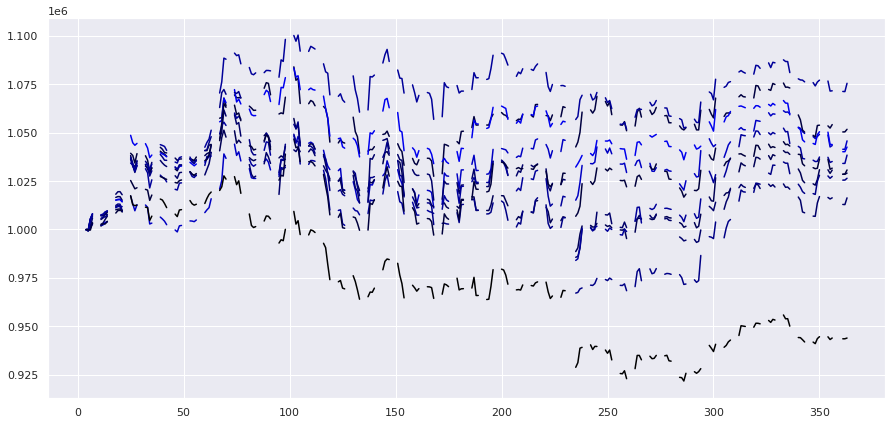

In [19]:
def f_c_rn(agt):
    return (0,0,rn.random())

plot_trading(agts=agts_rn, f_color=f_c_rn)

---
#### Baseline 
Variations in memory

In [23]:
mkt = Market(d=dt.date(year,1,1))
agts_bl_m = [Baseline(mem=i) for i in range(1,11)]

In [24]:
run_trading(mkt, agts_bl_m)

	100.0% [######################################################################]
runtime: 2.70 min


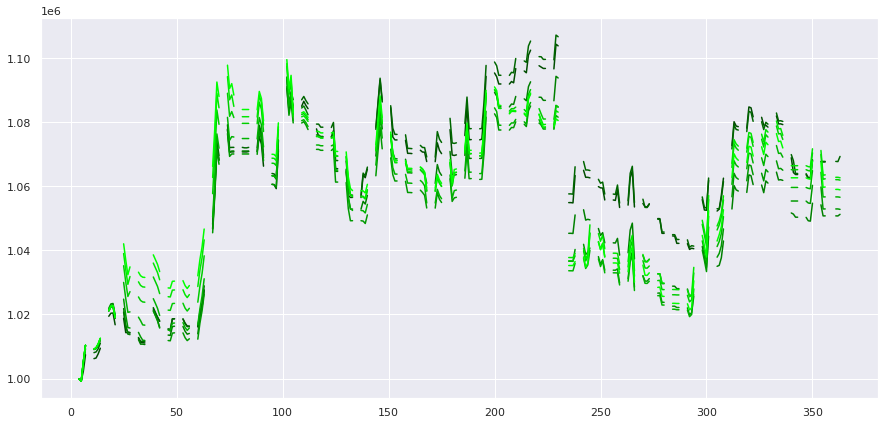

In [25]:
def f_c_bl_m(agt):
    return (0,agt.memory/10,0)

plot_trading(agts_bl_m, f_c_bl_m)

---
#### Hidden Markov

In [15]:
date = dt.date(year,1,1)
mkt = Market(d=date)
agts_hm = [HiddenMarkov(data, date, dm=j, wm=i, rt=1e-5) for i in [1, 20] for j in [.1, 5, 10]]

In [16]:
run_trading(mkt, agts_hm)

	100.0% [######################################################################]
runtime: 47.12 min


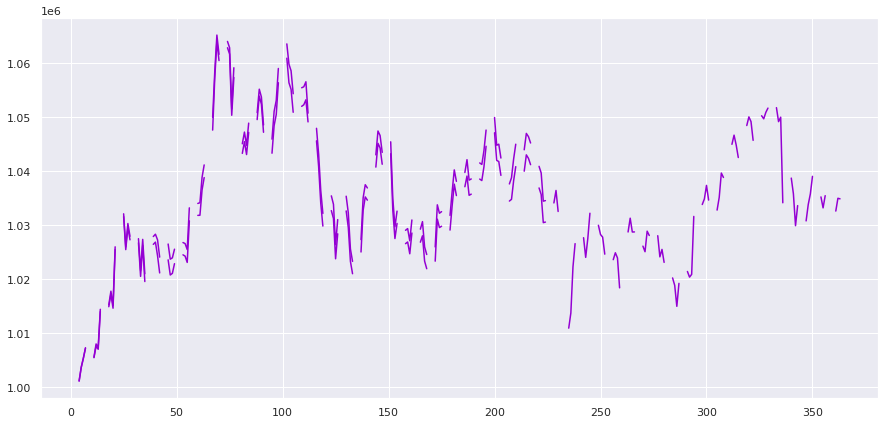

In [17]:
def f_c(agt):
    return 'darkviolet'

plot_trading(agts=agts_hm[1:3], f_color=f_c)

---
---
### How to improve?

$\;\;\;\;\bullet\;$ different Tag structure: e.g. bid-ask spread, EoD/Intraday

$\;\;\;\;\bullet\;$ more complexity $\rightarrow$ more data

$\;\;\;\;\bullet\;$ ML algorithms to optimize model parameters dynamically

$\;\;\;\;\bullet\;$ rebalancing the account costs money, how can we save on that?

$\;\;\;\;\bullet\;$ improving new tag handling in recursion